In [54]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model='gpt-4o-mini')
llm.invoke("what is capital of France").content


'The capital of France is Paris.'

In [55]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#example Analists
#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [56]:
# To validate base model use pydantic model
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    

    # To return json format of the persona
    @property     # simplyfy the informtion return f string
    def persona(self) -> str:
                return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [57]:
# Initilazing the analist
analist=Analyst(
    name="koraboina Raju",
    role="genai eng",
    affiliation="consultant",
    description="I am genai developer "
    )

In [58]:
analist.name

'koraboina Raju'

In [59]:
print(analist.persona)   # print all the details in single short

Name: koraboina Raju
Role: genai eng
Affiliation: consultant
Description: I am genai developer 



In [60]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [61]:
# taking the input from the user

class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [80]:
# printing dict bz of typeDict
GenerateAnalystsState(
    topic = "finances",
    max_analysts= 1,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finances',
 'max_analysts': 1,
 'human_analyst_feedback': 'give the real info'}

In [81]:
# not printing dict bz of this is basemodel
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    )

Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.')

In [82]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [83]:
# List of analist creation instructions  this prompt going to llm
print([analyst_instructions.format(
        topic="education",
        max_analysts=2,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 2 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


In [84]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    print(analysts)
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [85]:
analysts

[Analyst(name='Alice Chen', role='Startup Growth Analyst', affiliation='Tech Innovations Co.', description='Alice focuses on how adopting Langgraph can facilitate rapid application development for startups, reducing time-to-market and enabling agile methodologies that cater to evolving enterprise needs.'),
 Analyst(name='David Patel', role='Enterprise Solutions Strategist', affiliation='Global Enterprises Inc.', description='David specializes in identifying the advantages of Langgraph in large-scale enterprise applications, assessing its impact on operational efficiency, integration with existing systems, and overall productivity.'),
 Analyst(name='Maria Gomez', role='AI Adoption Specialist', affiliation='NextGen AI Solutions', description='Maria is dedicated to exploring the transformative potential of Langgraph in AI implementations, especially in enhancing collaboration among teams and embedding AI across various enterprise functions.')]

In [79]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

analysts=[Analyst(name='Dr. Sarah Thompson', role='Public Health Researcher', affiliation='National Institute of Health', description='Dr. Thompson focuses on the analysis of health disparities in various populations, emphasizing accessibility to healthcare services and preventive measures. Her primary concern is to provide real data that can influence policy changes aimed at improving health equity.'), Analyst(name='John Carter', role='Health Data Analyst', affiliation='Center for Disease Control and Prevention', description='John specializes in the interpretation of health data trends, particularly in relation to chronic diseases and their impact on public health. He is driven by the need for accurate and actionable health statistics that can inform treatment strategies and healthcare management.')]


{'analysts': [Analyst(name='Dr. Sarah Thompson', role='Public Health Researcher', affiliation='National Institute of Health', description='Dr. Thompson focuses on the analysis of health disparities in various populations, emphasizing accessibility to healthcare services and preventive measures. Her primary concern is to provide real data that can influence policy changes aimed at improving health equity.'),
  Analyst(name='John Carter', role='Health Data Analyst', affiliation='Center for Disease Control and Prevention', description='John specializes in the interpretation of health data trends, particularly in relation to chronic diseases and their impact on public health. He is driven by the need for accurate and actionable health statistics that can inform treatment strategies and healthcare management.')]}

HUMAN FEEDBACK

In [29]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [30]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

FIRST WORK FLOW

In [31]:
builder = StateGraph(GenerateAnalystsState)

In [32]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [33]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [35]:
memory = MemorySaver()
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

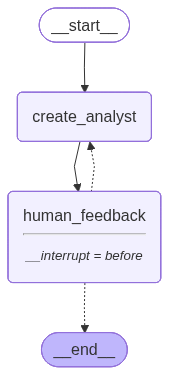

In [36]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [37]:
topic = "the benefits of adopting Langgraph as an agent framework"
max_analysts = 3
thread =  {"configurable":{"thread_id":1}}

In [38]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            

Name: Dr. Emily Tanner
Affiliation: Tech Innovations Lab
Role: AI Integration Specialist
Description: Dr. Tanner focuses on the seamless integration of new frameworks like Langgraph into existing systems. She is particularly interested in enhancing the interoperability of AI agents with legacy technology, ensuring that organizations can leverage Langgraph without extensive overhauls.
--------------------------------------------------
Name: Mr. David Chang
Affiliation: Data-Driven Insights Inc.
Role: Performance Analyst
Description: Mr. Chang analyzes the performance metrics associated with adopting agent frameworks such as Langgraph. His work emphasizes the quantitative benefits, including improvements in processing speed and efficiency, helping businesses understand the ROI of implementing Langgraph.
--------------------------------------------------
Name: Sarah Khan
Affiliation: UX Nexus
Role: User Experience Researcher
Description: Sarah Khan studies the impact of Langgraph on user 

In [39]:
state = graph.get_state(thread)

In [41]:
# containg the all the state information latest if u add diff appending this state
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 3, 'analysts': [Analyst(name='Dr. Emily Tanner', role='AI Integration Specialist', affiliation='Tech Innovations Lab', description='Dr. Tanner focuses on the seamless integration of new frameworks like Langgraph into existing systems. She is particularly interested in enhancing the interoperability of AI agents with legacy technology, ensuring that organizations can leverage Langgraph without extensive overhauls.'), Analyst(name='Mr. David Chang', role='Performance Analyst', affiliation='Data-Driven Insights Inc.', description='Mr. Chang analyzes the performance metrics associated with adopting agent frameworks such as Langgraph. His work emphasizes the quantitative benefits, including improvements in processing speed and efficiency, helping businesses understand the ROI of implementing Langgraph.'), Analyst(name='Sarah Khan', role='User Experience Researcher', affiliation='UX Nex

In [42]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 3,
 'analysts': [Analyst(name='Dr. Emily Tanner', role='AI Integration Specialist', affiliation='Tech Innovations Lab', description='Dr. Tanner focuses on the seamless integration of new frameworks like Langgraph into existing systems. She is particularly interested in enhancing the interoperability of AI agents with legacy technology, ensuring that organizations can leverage Langgraph without extensive overhauls.'),
  Analyst(name='Mr. David Chang', role='Performance Analyst', affiliation='Data-Driven Insights Inc.', description='Mr. Chang analyzes the performance metrics associated with adopting agent frameworks such as Langgraph. His work emphasizes the quantitative benefits, including improvements in processing speed and efficiency, helping businesses understand the ROI of implementing Langgraph.'),
  Analyst(name='Sarah Khan', role='User Experience Researcher', affiliation='UX Nexus', descriptio

In [44]:
state.next   # the next state is human feedback stopping here

('human_feedback',)

In [45]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d4d21-2a60-6f96-8001-de12eff84b23'}}

In [46]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d4d36-2d66-634a-8002-429acb874b1d'}}

In [47]:
# getting 6 analist details bz of privios 3 and new 3 total 6 using human feedback
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Tanner
Affiliation: Tech Innovations Lab
Role: AI Integration Specialist
Description: Dr. Tanner focuses on the seamless integration of new frameworks like Langgraph into existing systems. She is particularly interested in enhancing the interoperability of AI agents with legacy technology, ensuring that organizations can leverage Langgraph without extensive overhauls.
--------------------------------------------------
Name: Mr. David Chang
Affiliation: Data-Driven Insights Inc.
Role: Performance Analyst
Description: Mr. Chang analyzes the performance metrics associated with adopting agent frameworks such as Langgraph. His work emphasizes the quantitative benefits, including improvements in processing speed and efficiency, helping businesses understand the ROI of implementing Langgraph.
--------------------------------------------------
Name: Sarah Khan
Affiliation: UX Nexus
Role: User Experience Researcher
Description: Sarah Khan studies the impact of Langgraph on user 

In [48]:
state.next   # again getting human feedback state  

('human_feedback',)

In [49]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 3,
 'analysts': [Analyst(name='Dr. Emily Tanner', role='AI Integration Specialist', affiliation='Tech Innovations Lab', description='Dr. Tanner focuses on the seamless integration of new frameworks like Langgraph into existing systems. She is particularly interested in enhancing the interoperability of AI agents with legacy technology, ensuring that organizations can leverage Langgraph without extensive overhauls.'),
  Analyst(name='Mr. David Chang', role='Performance Analyst', affiliation='Data-Driven Insights Inc.', description='Mr. Chang analyzes the performance metrics associated with adopting agent frameworks such as Langgraph. His work emphasizes the quantitative benefits, including improvements in processing speed and efficiency, helping businesses understand the ROI of implementing Langgraph.'),
  Analyst(name='Sarah Khan', role='User Experience Researcher', affiliation='UX Nexus', descriptio